<a href="https://colab.research.google.com/github/mariiacamila31/Data-Science-Projects/blob/main/Unsupervised%20Learning%20Trading%20Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Unsupervised Learning Trading Strategy Used for Index Fund Rebalancing: Nasdaq Custom Made Portfolio vs. NASDAQ Composite**

1. Download **NASDAQ SCREENER** containing the names of the stocks that will be used in this project.
2. Download **NASDAQ COMPOSITE** (^IXIC) data from Yahoo Finance
3. Calculate different metrics and indicators on each stock.
4. Aggregate on a monthly level and filter 100 most liquid stocks.
5. Calculate Monthly Returns for different time-horizons.
6. Download Fama-French Factors and Calculate Rolling Factor Betas.
7. For each month fit a **K-Means** Clustering Algorithm to group similar assets based on their features.
8. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
9. Visualize **Portfolio returns** and compare to **NASDAQ COMPOSITE** returns.

*Note: The following analysis is **not** financial advice. This is just for educational purposes*

In [ ]:
# Import all packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
!pip install pandas_ta
import pandas_ta
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=8b6e4485c0f0ea7fb4d04e6740ae81e6da5806f720022c30affa9ebe8549aed1
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For efficiency purposes, the dataset that we are going to use includes only companies located in the US that have a market cap of at least $1 Billion.

The data was retrieved from:
https://www.nasdaq.com/market-activity/stocks/screener

##1. Download **NASDAQ SCREENER** containing the names of the stocks that will be used in this project.

In [ ]:
# Import the dataset
ixic = pd.read_csv("/content/drive/MyDrive/nasdaq.csv")
ixic["Symbol"] = ixic["Symbol"].str.replace(".", "-")
ixic

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$132.83,1.84,1.41%,"38,919,734,869.00",United States,1999.0,1407239,Industrials,Electrical Products
1,AAPL,Apple Inc. Common Stock,$191.73,-0.69,-0.36%,2.96E+12,United States,1980.0,47038247,Technology,Computer Manufacturing
2,ABBV,AbbVie Inc. Common Stock,$163.91,-0.49,-0.30%,2.89E+11,United States,2012.0,4704049,Health Care,Biotechnology: Pharmaceutical Preparations
3,ABNB,Airbnb Inc. Class A Common Stock,$152.70,3.08,2.06%,"99,016,491,609.00",United States,2020.0,5314941,Consumer Discretionary,Hotels/Resorts
4,ABT,Abbott Laboratories Common Stock,$113.45,1.44,1.29%,1.97E+11,United States,NaN,6479416,Health Care,Medical/Dental Instruments
...,...,...,...,...,...,...,...,...,...,...,...
643,ZBRA,Zebra Technologies Corporation Class A Common ...,$255.93,3.76,1.49%,"13,144,463,452.00",United States,1991.0,493220,Industrials,Industrial Machinery/Components
644,ZG,Zillow Group Inc. Class A Common Stock,$56.65,1.68,3.06%,"13,233,618,901.00",United States,2011.0,520038,Consumer Discretionary,Business Services
645,ZM,Zoom Video Communications Inc. Class A Common ...,$68.93,1.19,1.76%,"20,983,911,924.00",United States,2019.0,2655762,Technology,Computer Software: Programming Data Processing
646,ZS,Zscaler Inc. Common Stock,$245.05,8.22,3.47%,"36,349,110,697.00",United States,2018.0,1376897,Technology,EDP Services


In [ ]:
# Create a list with the symbols
symbols_list = ixic["Symbol"].tolist()
symbols_list

['A',
 'AAPL',
 'ABBV',
 'ABNB',
 'ABT',
 'ACI',
 'ACM',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AESC',
 'AFG',
 'AFL',
 'AFRM',
 'AGNCL',
 'AGNCM',
 'AGNCN',
 'AGNCO',
 'AGNCP',
 'AGR',
 'AIG',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'ALLY',
 'ALNY',
 'AMAT',
 'AMD',
 'AME',
 'AMGN',
 'AMH',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APD',
 'APH',
 'APO',
 'APP',
 'AQNB',
 'AQNU',
 'ARCC',
 'ARE',
 'ARES',
 'ASBA',
 'ATO',
 'AVB',
 'AVGO',
 'AVTR',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'AZPN',
 'BA',
 'BAC',
 'BAH',
 'BALL',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BG',
 'BIIB',
 'BK',
 'BKDT',
 'BKNG',
 'BKR',
 'BLD',
 'BLDR',
 'BLK',
 'BMRN',
 'BMY',
 'BR',
 'BRK-A',
 'BRK-B',
 'BRKR',
 'BRO',
 'BSX',
 'BSY',
 'BURL',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CASY',
 'CAT',
 'CBRE',
 'CCI',
 'CCK',
 'CCL',
 'CDAY',
 'CDNS',
 'CDW',
 'CE',
 'CEG',
 'CELH',
 'CF',
 'CFG',
 'CG',
 'CHD',
 'CHK',
 'CHRW',
 'CHTR',
 'CI',
 'CIN

In [ ]:
# Set the dates for the analysis
end_date = "2023-12-31"

# The start day will be set to exactly 5 years from the end date
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*5)

## 2. Download **NASDAQ COMPOSITE** (^IXIC) data from Yahoo Finance

In [ ]:
# Download each ticker's information from Yahoo Finance
data = yf.download(tickers=symbols_list,
                   start=start_date,
                   end=end_date).stack()

data

[*********************100%%**********************]  648 of 648 completed


Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2019-01-02 A        63.381721   65.690002   66.570000   65.300003   66.500000   
           AAPL     37.893330   39.480000   39.712502   38.557499   38.722500   
           ABBV     69.977943   89.230003   91.260002   88.419998   91.239998   
           ABT      63.600914   69.500000   70.959999   69.070000   70.389999   
           ACM      26.364271   26.879999   27.100000   25.980000   26.090000   
...                       ...         ...         ...         ...         ...   
2023-12-29 ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZG       56.720001   56.720001   58.419998   56.590000   57.500000   
           ZM       71.910004   71.910004   73.598000   71.809998   72.980003   
           ZS      221.559998  221.559998  225.910004  220.869995  224.029999   
           ZTS     196.923355  197.369995  198.009995  196.250000  196.679993   

Price                   Volume  
Date       Ticker               
2019-01-02 A         2113300.0  
           AAPL    148158800.0  
           ABBV      6908400.0  
           ABT       8737200.0  
           ACM       1041300.0  
...                        ...  
2023-12-29 ZBRA       251300.0  
           ZG         706400.0  
           ZM        2425900.0  
           ZS         804800.0  
           ZTS       1007200.0  

[783435 rows x 6 columns]

In [ ]:
# Change the column names to lower case for preprocessing
data.index.names = ["date", "ticker"]
data.columns =  data.columns.str.lower()
data

Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-01-02 A        63.381721   65.690002   66.570000   65.300003   66.500000   
           AAPL     37.893330   39.480000   39.712502   38.557499   38.722500   
           ABBV     69.977943   89.230003   91.260002   88.419998   91.239998   
           ABT      63.600914   69.500000   70.959999   69.070000   70.389999   
           ACM      26.364271   26.879999   27.100000   25.980000   26.090000   
...                       ...         ...         ...         ...         ...   
2023-12-29 ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZG       56.720001   56.720001   58.419998   56.590000   57.500000   
           ZM       71.910004   71.910004   73.598000   71.809998   72.980003   
           ZS      221.559998  221.559998  225.910004  220.869995  224.029999   
           ZTS     196.923355  197.369995  198.009995  196.250000  196.679993   

Price                   volume  
date       ticker               
2019-01-02 A         2113300.0  
           AAPL    148158800.0  
           ABBV      6908400.0  
           ABT       8737200.0  
           ACM       1041300.0  
...                        ...  
2023-12-29 ZBRA       251300.0  
           ZG         706400.0  
           ZM        2425900.0  
           ZS         804800.0  
           ZTS       1007200.0  

[783435 rows x 6 columns]

##3. Calculate different metrics and indicators for each stock.

####Summary of metrics:

* **Garman-Klass Volatility:** A volatility estimator that incorporates high, low and closing prices of a security.

* **Relative Strength Index (RSI):** A technical indicator that is used in momentum trading that measures the speed and magnitude of price changes

* **Bollinger Bands (BB):** A technical analysis tool defined by a set of trendlines. It is composed of three lines: Low, mid (Simple Moving Average) and high band. These are used to determine if prices are high or low relative to each other.

* **Average true range (ATR):** The true ranges over the pre-determined period that we choose for our analysis. ATR measures volatility including the price gap movements.


* **Moving Average Convergence/Divergence (MACD):** Is a trend following indicator that uses trends to show the relationship between 2 exponential moving averages of a securiy's price.

We use the *adjusted closing* price to better reflect the stock's value throught the year.

In [ ]:
# Formula for Garman-klass
data["garman_klass_vol"] = ((np.log(data["high"])-np.log(data["low"]))**2)/2-(2*np.log(2)-1)*((np.log(data["adj close"])-np.log(data["open"]))**2)


# Relative Strength Index (RSI)
#This part (RSI) involves the use of the transform method, which applies a function to each group independently and then combines the results back into the original DataFrame.
data["rsi"] = data.groupby(level=1)["adj close"].transform(lambda x:pandas_ta.rsi(close=x, length=20))

# Bollinger Bands (BB)
data["bb_low"] = data.groupby(level=1)["adj close"].transform(lambda x:pandas_ta.bbands(close=np.log(x), length=20).iloc[:,0])
data["bb_mid"] = data.groupby(level=1)["adj close"].transform(lambda x:pandas_ta.bbands(close=np.log(x), length=20).iloc[:,0])
data["bb_high"] = data.groupby(level=1)["adj close"].transform(lambda x:pandas_ta.bbands(close=np.log(x), length=20).iloc[:,0])


# Customized function to compute ATR
def compute_atr(stock_data):
  atr = pandas_ta.atr(high=stock_data["high"],
              low=stock_data["low"],
              close=stock_data["adj close"],
              length=14)

  return atr.sub(atr.mean()).div(atr.std()) #normalize the data, divide by the Standard Deviation

data["atr"] = data.groupby(level=1, group_keys=False).apply(compute_atr)

# Customized function to compute MACD
def compute_macd(close):
  macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std()) #dividing by the SD normalizes the data

data["macd"] = data.groupby(level=1, group_keys=False)["adj close"].apply(compute_macd)

# Calculate the dollar volume. We divide by 1 million to normalize
data["dollar_volume"] = (data["adj close"]*data["volume"])/1e6

##4. Aggregate on a monthly level and filter 100 most liquid stocks for each month

Now that we had a quick look at the entire data, we can start to focus on the desired stocks for our portfolio.

In [ ]:
# Select the exact columns. We will be using only the metrics from above for the selection of the securities
last_cols = [c for c in data.columns.unique(0) if c not in ["dollar_volume",
                                                          "volume",
                                                          "open",
                                                          "high",
                                                          "low",
                                                          "close"]]
# Convert the stacked monthly averages into a df
df = (pd.concat([data.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   data.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

df

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2019-02-28 A          141.497211   76.648552 -0.563220  4.278833  4.278833   
           AAPL      4110.705749   41.725998 -1.598656  3.691625  3.691625   
           ABBV       362.013133   62.905552  1.451364  4.133047  4.133047   
           ABT        391.114849   71.361069  0.564378  4.185343  4.185343   
           ACM         30.496391   30.365995 -1.675567  3.345667  3.345667   
...                          ...         ...       ...       ...       ...   
2023-12-31 ZBRA        98.037275  273.329987 -0.966136  5.411473  5.411473   
           ZG          51.752414   56.720001 -0.560684  3.668325  3.668325   
           ZM         349.921352   71.910004 -0.960345  4.229638  4.229638   
           ZS         374.336327  221.559998 -0.449158  5.260388  5.260388   
           ZTS        334.396200  196.923355 -1.785071  5.178581  5.178581   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2019-02-28 A       4.278833         -0.000349  0.811302  71.811745  
           AAPL    3.691625         -0.000665  0.133139  63.440845  
           ABBV    4.133047         -0.021010 -0.855343  40.438019  
           ABT     4.185343         -0.002150  1.013859  68.725583  
           ACM     3.345667         -0.000013  0.115810  61.880269  
...                     ...               ...       ...        ...  
2023-12-31 ZBRA    5.411473          0.000073  1.280107  67.914673  
           ZG      3.668325          0.000434  1.471876  69.969217  
           ZM      4.229638          0.000218  0.164956  56.613617  
           ZS      5.260388          0.000207  1.401866  70.363742  
           ZTS     5.178581          0.000039  1.708543  66.791324  

[36738 rows x 9 columns]

**We reduced our data by 95.3%, now we can focus on the "best" securities that should be in our ideal portfolio**

## **Quick analysis using the metrics from above:**

For this analysis we will use the last stock on the dataframe **Zoetis (ZTS)**. Zoetis Inc. is an American drug company, the world's largest producer of medicine and vaccinations for pets and livestock. The company was a subsidiary of Pfizer, the world's largest drug maker, but with Pfizer's spinoff of its 83% interest in the firm it is now a completely independent company.

On December 29th of 2023, the **adjusted closing price was $196.92** These are some of the things that we can conclude for that day using our calculated metrics:

  1. **Garman-Klass Volatility** = 0.000039 or 0.0039%. This indicates the extremely low volatility levels for the stock. This makes this security an ideal component for a portfolio with a risk averse approach, meant to protect the investor's principal, and to generate a small, steady margin in the long-term.

  2. **RSI** = 66.97. A security that has an RSI score of 70 or above is considered to be overbought, suggesting overvaluation. This represents a bearish future, but because the RSI is still below 70, we could say that the stock could potentially become overvalued.

  3. **Bollinger Bands** = 5.178581, not surprisingly, the value for the three bands (low, mid and high) is the same. This is a clear indicator of the stock's behavior, we could technically say that "the stock stays within the same price range".

  4. **ATR** = -$1.78 The average true range represents the difference between the lowest and highest price for a security throughout a trading day. The ATR is simply reflecting the price drop for the day which is below 2 dollars and less than 1% of the security's current price.

  5.**MACD:** = A MACD score above 0, or simply positive, is considered a bullish indicator for the security.

  ## **Conclusion:**
  
  Based on the results, we can conclude that on the last trading day of 2023, ZTS was considered a safe and non-volatile investment to pursue. Both the Garman-Klass volatility and Bollinger Bands are a  reflection of the small price changes of the security for the day. If we take into consideration the MACD score, we would expect for this security's price to continue rising in the short-term.

### **Note:** We will calculate a 5-year rolling average. This refers to the calculation of the average value of a financial metric over a rolling period of 5 years. This involves taking a window of the most recent 5 years of data, calculating the average, and then moving the window forward in time.

In [ ]:
# 5-year rolling average for the dollar volume for each stock
df["dollar_volume"] = (df.loc[:,"dollar_volume"].unstack("ticker").rolling(5*12, min_periods=12).mean().stack())

# Create a new column to rank the dollar volume per stock
df["dollar_vol_rank"] = (df.groupby("date")["dollar_volume"].rank(ascending=False))

# This is how we select the 100 most liquid stocks over the years
df[df["dollar_volume"]<=100]

df

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2019-02-28 A                 NaN   76.648552 -0.563220  4.278833  4.278833   
           AAPL              NaN   41.725998 -1.598656  3.691625  3.691625   
           ABBV              NaN   62.905552  1.451364  4.133047  4.133047   
           ABT               NaN   71.361069  0.564378  4.185343  4.185343   
           ACM               NaN   30.365995 -1.675567  3.345667  3.345667   
...                          ...         ...       ...       ...       ...   
2023-12-31 ZBRA       125.975706  273.329987 -0.966136  5.411473  5.411473   
           ZG          49.084582   56.720001 -0.560684  3.668325  3.668325   
           ZM        1055.364451   71.910004 -0.960345  4.229638  4.229638   
           ZS         347.121179  221.559998 -0.449158  5.260388  5.260388   
           ZTS        304.696928  196.923355 -1.785071  5.178581  5.178581   

                     bb_mid  garman_klass_vol      macd        rsi  \
date       ticker                                                    
2019-02-28 A       4.278833         -0.000349  0.811302  71.811745   
           AAPL    3.691625         -0.000665  0.133139  63.440845   
           ABBV    4.133047         -0.021010 -0.855343  40.438019   
           ABT     4.185343         -0.002150  1.013859  68.725583   
           ACM     3.345667         -0.000013  0.115810  61.880269   
...                     ...               ...       ...        ...   
2023-12-31 ZBRA    5.411473          0.000073  1.280107  67.914673   
           ZG      3.668325          0.000434  1.471876  69.969217   
           ZM      4.229638          0.000218  0.164956  56.613617   
           ZS      5.260388          0.000207  1.401866  70.363742   
           ZTS     5.178581          0.000039  1.708543  66.791324   

                   dollar_vol_rank  
date       ticker                   
2019-02-28 A                   NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
           ACM                 NaN  
...                            ...  
2023-12-31 ZBRA              381.0  
           ZG                572.0  
           ZM                 36.0  
           ZS                147.0  
           ZTS               172.0  

[36738 rows x 10 columns]

##5. Calculate Monthly Returns for different time horizons.

To capture time series dynamics that reflect **momentum patterns**, we compute historical returns using the method .pct_change(lag) that shows returns over various monthly periods.

In [ ]:
# We will create a formula that will calculate this for the entire set of stocks
def calculate_returns(data):

    # Clip the outlier values during the pre-define time frames
    # We set an outlier threshold to remove these
    # This would refer to the 99.995 percentile
    outlier_cutoff = 0.005

    #number of months
    lags = [1, 2, 3, 6, 9, 12]

    #pct_change(lag) -> percent change

    for lag in lags:
      data[f"return_{lag}m"] = (data["adj close"]
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return data

df = df.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
df

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2020-02-29 A          157.819011   74.996582 -0.901464  4.317880  4.317880   
           AAPL      6406.207026   66.737022 -0.463032  4.218705  4.218705   
           ABBV       517.878804   71.975410  0.992411  4.219790  4.219790   
           ABT        384.562571   71.965279  0.299310  4.303663  4.303663   
           ACM         42.558354   44.077770 -0.288003  3.785244  3.785244   
...                          ...         ...       ...       ...       ...   
2023-12-31 ZBRA       125.975706  273.329987 -0.966136  5.411473  5.411473   
           ZG          49.084582   56.720001 -0.560684  3.668325  3.668325   
           ZM        1055.364451   71.910004 -0.960345  4.229638  4.229638   
           ZS         347.121179  221.559998 -0.449158  5.260388  5.260388   
           ZTS        304.696928  196.923355 -1.785071  5.178581  5.178581   

                     bb_mid  garman_klass_vol      macd        rsi  \
date       ticker                                                    
2020-02-29 A       4.317880          0.000735 -1.009013  32.603360   
           AAPL    4.218705          0.002873 -1.026362  34.635027   
           ABBV    4.219790         -0.006350 -0.125353  43.431997   
           ABT     4.303663         -0.000368 -1.455819  26.562261   
           ACM     3.785244          0.000628 -0.229033  41.164991   
...                     ...               ...       ...        ...   
2023-12-31 ZBRA    5.411473          0.000073  1.280107  67.914673   
           ZG      3.668325          0.000434  1.471876  69.969217   
           ZM      4.229638          0.000218  0.164956  56.613617   
           ZS      5.260388          0.000207  1.401866  70.363742   
           ZTS     5.178581          0.000039  1.708543  66.791324   

                   dollar_vol_rank  return_1m  return_2m  return_3m  \
date       ticker                                                     
2020-02-29 A                 237.0  -0.066497  -0.049521  -0.014816   
           AAPL                2.0  -0.114702  -0.034022   0.008360   
           ABBV               53.0   0.057887  -0.009487  -0.003286   
           ABT                84.0  -0.108936  -0.056286  -0.032622   
           ACM               511.0  -0.068215   0.020767   0.012235   
...                            ...        ...        ...        ...   
2023-12-31 ZBRA              381.0   0.153388   0.142416   0.049382   
           ZG                572.0   0.421868   0.263486   0.081895   
           ZM                 36.0   0.060150   0.094943   0.009302   
           ZS                147.0   0.121652   0.181601   0.125045   
           ZTS               172.0   0.117168   0.112340   0.043775   

                   return_6m  return_9m  return_12m  
date       ticker                                    
2020-02-29 A        0.014224   0.016324   -0.001814  
           AAPL     0.046912   0.051828    0.039912  
           ABBV     0.050073   0.017255    0.011287  
           ABT     -0.015540   0.002640    0.000703  
           ACM      0.040179   0.038815    0.031540  
...                      ...        ...         ...  
2023-12-31 ZBRA    -0.013098  -0.016678    0.005339  
           ZG       0.023989   0.029399    0.051042  
           ZM       0.009659  -0.002938    0.004991  
           ZS       0.071621   0.073697    0.058575  
           ZTS      0.023770   0.019882    0.025896  

[28980 rows x 16 columns]

##6. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

**The five Fama—French factors are:**
 1. Size
 2. Quality
 3. Profitability
 4. Value
 5. Investment Pattern

These explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.



* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using RollingOLS, rolling linear regression.

In [ ]:
# Download the fama-french factors
factor_data = web.DataReader("F-F_Research_Data_5_Factors_2x3",
                             "famafrench",
                             start="2010")[0].drop("RF", axis=1)

# Since the indices are dates, we need to convert these to "timestamp" format
factor_data.index = factor_data.index.to_timestamp()

# Resample to monthly
factor_data = factor_data.resample("M").last().div(100)

factor_data.index.name = "date"

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-08-31,-0.0239,-0.0365,-0.0106,0.0343,-0.0237
2023-09-30,-0.0524,-0.0180,0.0152,0.0186,-0.0083
2023-10-31,-0.0319,-0.0404,0.0019,0.0246,-0.0066


* **Profitability (MKT):** The excess return of the market. It is the return on the value-weighted market portfolio.

* **Size (SMB):** The return on a diversified portfolio of small-cap stocks minus the return on a diversified portfolio of big-cap stocks.

* **Value (HML):** The difference between the returns on diversified portfolios of stocks with high and low Book-to-Market ratios.

* **Quality (RMW):** The difference between the returns on diversified portfolios of stocks with robust (high and steady) and weak (low) profitability.

* **Investment Pattern (CMA):** The difference between the returns on diversified portfolios of the stocks of low and high investment firms, which we call conservative and aggressive. Here, low/high investment means reinvestment ratio is low/high.

In [ ]:
# Here we add the column "return_1m" from "data" then we sort by index for both
factor_data = factor_data.join(df["return_1m"]).sort_index()

# Example of the results using ZTS from the analysis from above:
factor_data.xs("ZTS", level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2020-02-29,-0.0813,0.0004,-0.0381,-0.0147,-0.0251,-0.007302
2020-03-31,-0.1339,-0.0828,-0.1387,-0.0157,0.0124,-0.116640
2020-04-30,0.1365,0.0256,-0.0133,0.0272,-0.0100,0.100512
2020-05-31,0.0558,0.0197,-0.0488,0.0095,-0.0326,0.077952
2020-06-30,0.0246,0.0196,-0.0220,0.0009,0.0054,-0.016859


In [ ]:
# Filter out stocks with less than 12 months worth of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 12] # Referring to the 12 months min threshold

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2020-02-29 A      -0.0813  0.0004 -0.0381 -0.0147 -0.0251  -0.066497
           AAPL   -0.0813  0.0004 -0.0381 -0.0147 -0.0251  -0.114702
           ABBV   -0.0813  0.0004 -0.0381 -0.0147 -0.0251   0.057887
           ABT    -0.0813  0.0004 -0.0381 -0.0147 -0.0251  -0.108936
           ACM    -0.0813  0.0004 -0.0381 -0.0147 -0.0251  -0.068215
...                   ...     ...     ...     ...     ...        ...
2023-12-31 ZBRA    0.0485  0.0732  0.0494 -0.0307  0.0132   0.153388
           ZG      0.0485  0.0732  0.0494 -0.0307  0.0132   0.421868
           ZM      0.0485  0.0732  0.0494 -0.0307  0.0132   0.060150
           ZS      0.0485  0.0732  0.0494 -0.0307  0.0132   0.121652
           ZTS     0.0485  0.0732  0.0494 -0.0307  0.0132   0.117168

[28952 rows x 6 columns]

### **Rolling Factor Betas:**

* Beta is a measure of a security's volatility compared to the market as a whole.

* A Rolling factor beta refers to a time-varying measure of an asset's sensitivity to market movements, specifically changes in a benchmark index.

* A positive beta indicates that the asset tends to move in the same direction as the overall market.

* A beta greater than 1 suggests the asset is more volatile than the market, and viceversa.

In [ ]:
# Calculate Rolling Factor Betas
betas = (factor_data.groupby(level=1,
                      group_keys=False)
  .apply(lambda x: RollingOLS(endog=x["return_1m"],
                              exog=sm.add_constant(x.drop("return_1m", axis=1)),
                              window=min(24, x.shape[0]),
                              min_nobs=len(x.columns)+1)
  .fit(params_only=True)
  .params
  .drop("const", axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2020-02-29 A            NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACM          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-12-31 ZBRA    1.599268  0.885350 -0.080392  0.198872 -0.344908
           ZG      1.804602  2.451315 -0.254735  0.196762  0.102330
           ZM      0.763898  0.653825  0.968889  0.441165 -1.753122
           ZS      0.432160 -0.030280  0.643050 -2.365274 -2.896266
           ZTS     0.781506  1.197899 -0.330227  0.675333 -0.035165

[28952 rows x 5 columns]

Because we can only get our predictions at the end of the month, we need to shift the data. This is because we would know the ending value of a stock from October at the beginning of November.

In [ ]:
betas.shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2020-02-29 A            NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACM          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-12-31 ZBRA    0.898652  0.128563 -0.647048 -0.238291  1.457347
           ZG      1.599268  0.885350 -0.080392  0.198872 -0.344908
           ZM      1.804602  2.451315 -0.254735  0.196762  0.102330
           ZS      0.763898  0.653825  0.968889  0.441165 -1.753122
           ZTS     0.432160 -0.030280  0.643050 -2.365274 -2.896266

[28952 rows x 5 columns]

In [ ]:
# Impute the missing values of each factor
factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]

df = (df.join(betas.groupby("ticker").shift()))

# Select all the rows and factors from df and impute the mean for any missing values
df.loc[:, factors] = df.groupby("ticker", group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28472 entries, (Timestamp('2020-02-29 00:00:00', freq='M'), 'A') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'ZTS')
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dollar_volume     28472 non-null  float64
 1   adj close         28472 non-null  float64
 2   atr               28472 non-null  float64
 3   bb_high           28472 non-null  float64
 4   bb_low            28472 non-null  float64
 5   bb_mid            28472 non-null  float64
 6   garman_klass_vol  28472 non-null  float64
 7   macd              28472 non-null  float64
 8   rsi               28472 non-null  float64
 9   dollar_vol_rank   28472 non-null  float64
 10  return_1m         28472 non-null  float64
 11  return_2m         28472 non-null  float64
 12  return_3m         28472 non-null  float64
 13  return_6m         28472 non-null  float64
 14  return_9m         28472 non-null  float6

In [ ]:
# Drop columns not needed for the model
df = df.drop("dollar_volume", axis=1)
df = df.drop("adj close", axis=1)
df = df.drop("dollar_vol_rank", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28472 entries, (Timestamp('2020-02-29 00:00:00', freq='M'), 'A') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'ZTS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               28472 non-null  float64
 1   bb_high           28472 non-null  float64
 2   bb_low            28472 non-null  float64
 3   bb_mid            28472 non-null  float64
 4   garman_klass_vol  28472 non-null  float64
 5   macd              28472 non-null  float64
 6   rsi               28472 non-null  float64
 7   return_1m         28472 non-null  float64
 8   return_2m         28472 non-null  float64
 9   return_3m         28472 non-null  float64
 10  return_6m         28472 non-null  float64
 11  return_9m         28472 non-null  float64
 12  return_12m        28472 non-null  float64
 13  Mkt-RF            28472 non-null  float64
 14  SMB               28472 non-null  float6

**Now we can decide which stocks we will be choosing for the portfolio.**

##7. Modelling: K-means

Our approach will be to fit a K-Means Clustering Algorithm for each month to group similar assets based on their features and metrics. By using clusters, we will try to find patters using the RSI score which will indicate the best investments.


*Run the line of code that defines the initial centroids once you have ran the get_clusters(data) function using init="random". The idea is to rerun the code once we have the target RSI values for the clusters after they have been generated*

In [ ]:
# These will be the desired categories for each cluster (RSI values) for the stocks to be classified on each cluster for each month
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))#we will use the length of the target values (4) and the 18 features
initial_centroids[:, 6] = target_rsi_values
initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
from sklearn.cluster import KMeans

df = df.drop("cluster", axis=1)

# Create a function that will
def get_clusters(data):
  data["cluster"] = KMeans(n_clusters=4,
                           random_state=42,
                           init=initial_centroids).fit(data).labels_
  return data

df = df.dropna().groupby("date", group_keys=False).apply(get_clusters)
df

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2020-02-29 A      -0.901464  4.317880  4.317880  4.317880          0.000735   
           AAPL   -0.463032  4.218705  4.218705  4.218705          0.002873   
           ABBV    0.992411  4.219790  4.219790  4.219790         -0.006350   
           ABT     0.299310  4.303663  4.303663  4.303663         -0.000368   
           ACM    -0.288003  3.785244  3.785244  3.785244          0.000628   
...                     ...       ...       ...       ...               ...   
2023-12-31 ZBRA   -0.966136  5.411473  5.411473  5.411473          0.000073   
           ZG     -0.560684  3.668325  3.668325  3.668325          0.000434   
           ZM     -0.960345  4.229638  4.229638  4.229638          0.000218   
           ZS     -0.449158  5.260388  5.260388  5.260388          0.000207   
           ZTS    -1.785071  5.178581  5.178581  5.178581          0.000039   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2020-02-29 A      -1.009013  32.603360  -0.066497  -0.049521  -0.014816   
           AAPL   -1.026362  34.635027  -0.114702  -0.034022   0.008360   
           ABBV   -0.125353  43.431997   0.057887  -0.009487  -0.003286   
           ABT    -1.455819  26.562261  -0.108936  -0.056286  -0.032622   
           ACM    -0.229033  41.164991  -0.068215   0.020767   0.012235   
...                     ...        ...        ...        ...        ...   
2023-12-31 ZBRA    1.280107  67.914673   0.153388   0.142416   0.049382   
           ZG      1.471876  69.969217   0.421868   0.263486   0.081895   
           ZM      0.164956  56.613617   0.060150   0.094943   0.009302   
           ZS      1.401866  70.363742   0.121652   0.181601   0.125045   
           ZTS     1.708543  66.791324   0.117168   0.112340   0.043775   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2020-02-29 A        0.014224   0.016324   -0.001814  1.037118  0.302501   
           AAPL     0.046912   0.051828    0.039912  1.200044 -0.304468   
           ABBV     0.050073   0.017255    0.011287  0.646391  0.017771   
           ABT     -0.015540   0.002640    0.000703  0.709862  0.093796   
           ACM      0.040179   0.038815    0.031540  0.894512  0.754399   
...                      ...        ...         ...       ...       ...   
2023-12-31 ZBRA    -0.013098  -0.016678    0.005339  1.584686  0.675453   
           ZG       0.023989   0.029399    0.051042  1.799038  1.868472   
           ZM       0.009659  -0.002938    0.004991  0.725390  0.552989   
           ZS       0.071621   0.073697    0.058575  0.477684  0.016914   
           ZTS      0.023770   0.019882    0.025896  0.800889  1.136598   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2020-02-29 A      -0.075420  0.333733 -0.002930        1  
           AAPL   -0.612732  0.307719  0.459138        1  
           ABBV   -0.260869  0.411524  0.834228        1  
           ABT    -0.398321  0.451864  0.725438        0  
           ACM     0.018872  0.518296  0.022528        1  
...                     ...       ...       ...      ...  
2023-12-31 ZBRA   -0.097116  0.231565 -0.370271        2  
           ZG     -0.414766  0.548782  0.205084        3  
           ZM      1.063309  0.221246 -1.921509        1  
           ZS      0.509423 -2.056661 -2.681102        3  
           ZTS    -0.412000  0.861711  0.074653        2  

[28472 rows x 19 columns]

In [ ]:
# Now plot the results, this uses the RSI

def plot_clusters(df):
  cluster_0 = df[df["cluster"]==0]
  cluster_1 = df[df["cluster"]==1]
  cluster_2 = df[df["cluster"]==2]
  cluster_3 = df[df["cluster"]==3]

  plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = "red",label = "cluster 0")
  plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = "yellow",label = "cluster 1")
  plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = "green",label = "cluster 2")
  plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = "blue",label = "cluster 3")

  plt.legend()
  plt.show()
  return

Remember that the metric that we will use to create the plot is RSI:

**Relative Strength Index:** It is designed to measure the **magnitude and velocity of price movements in order to identify overbought or oversold conditions in a financial asset.**

•	An asset is usually considered overbought when the RSI is above 70 and oversold when it is below 30.

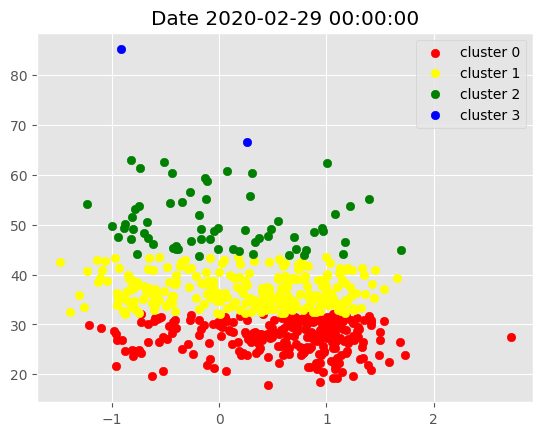

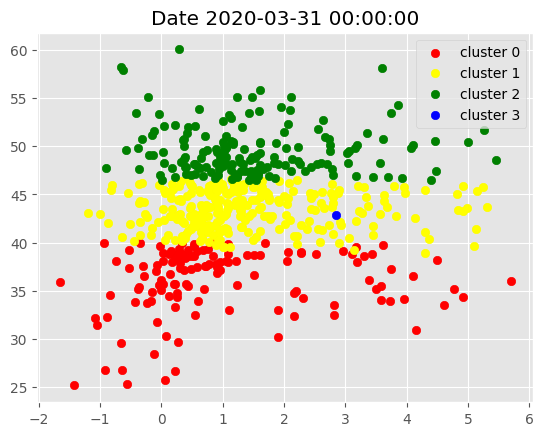

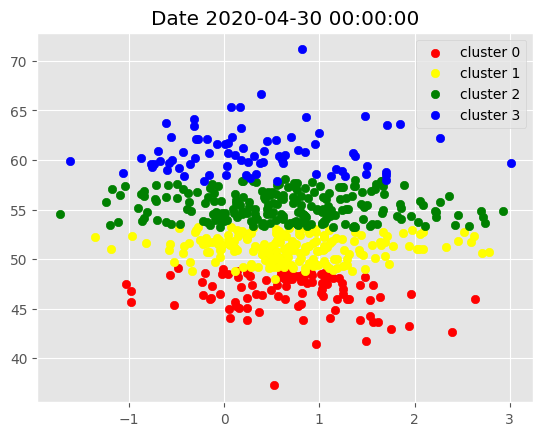

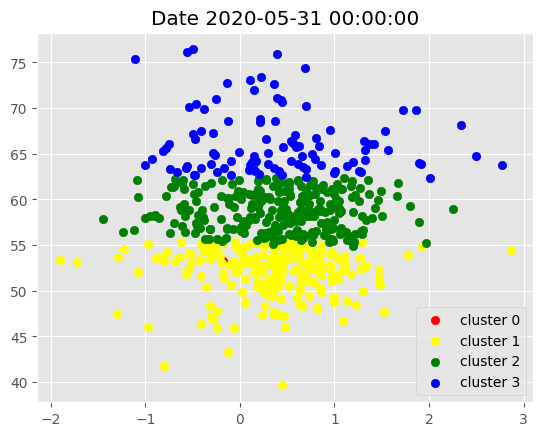

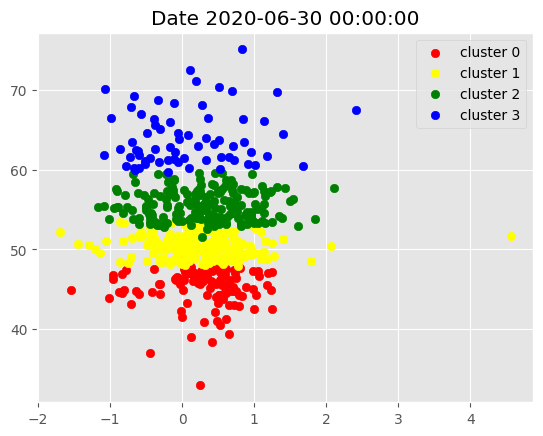

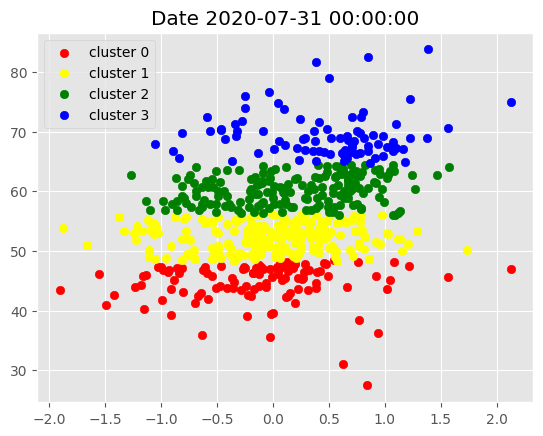

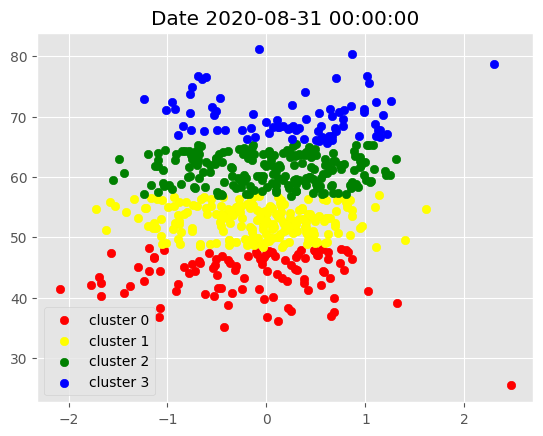

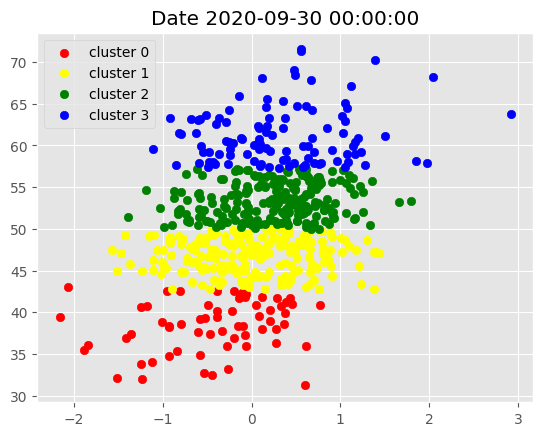

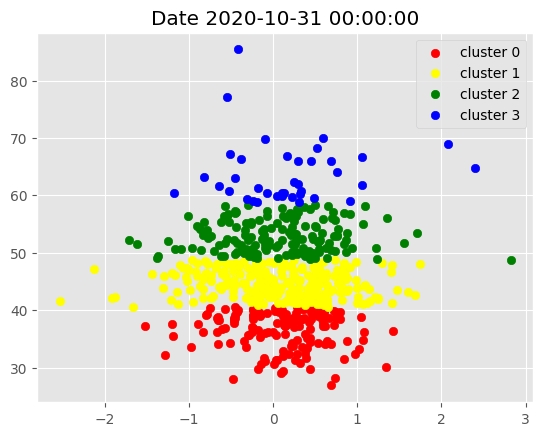

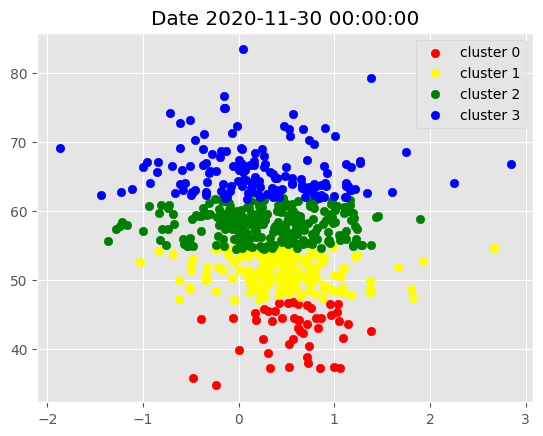

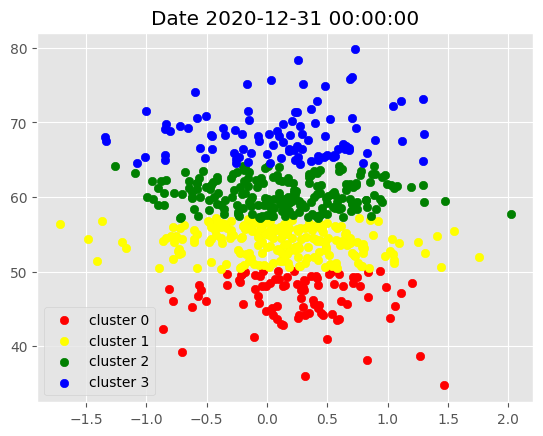

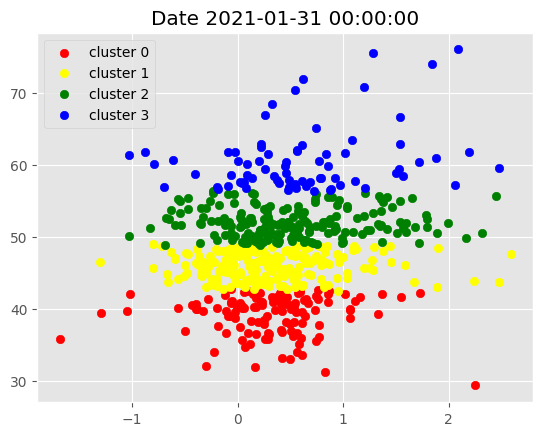

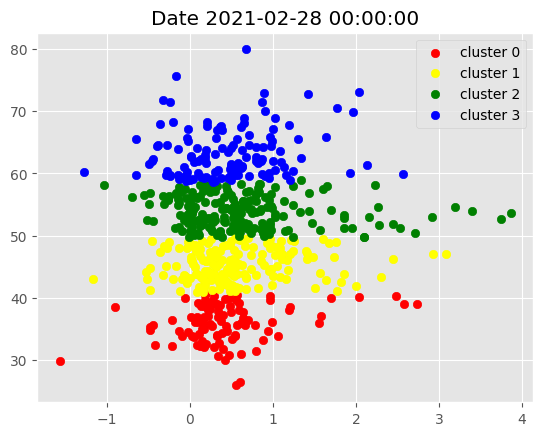

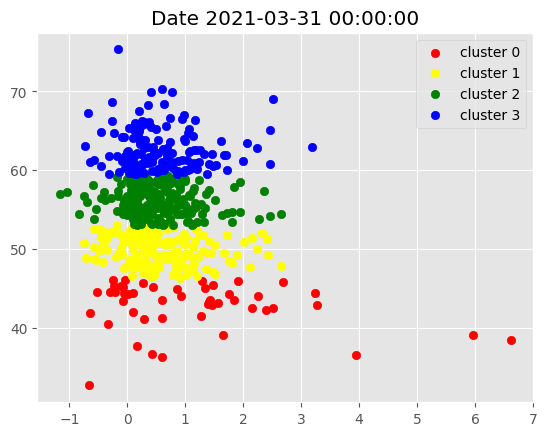

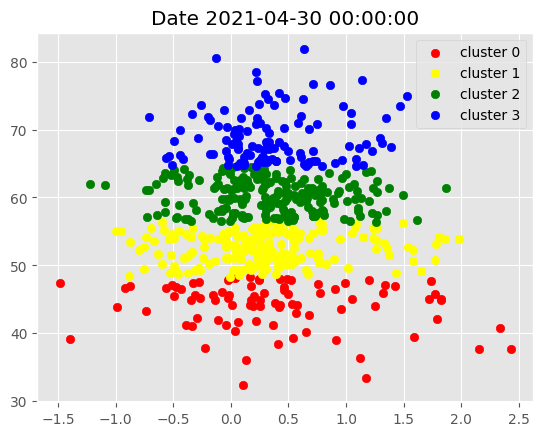

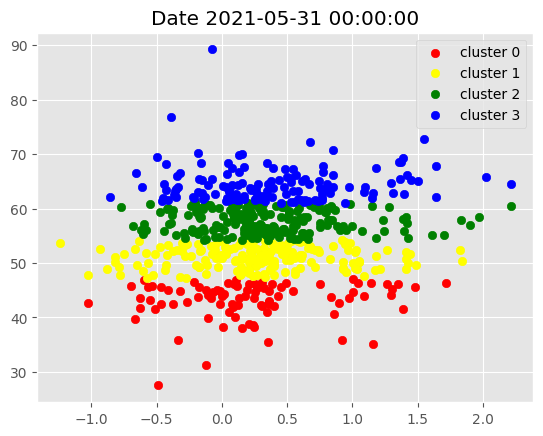

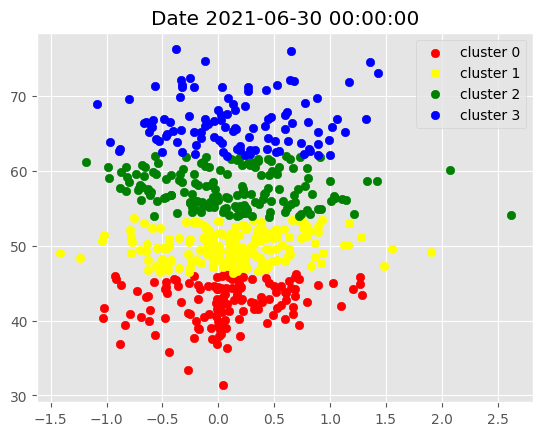

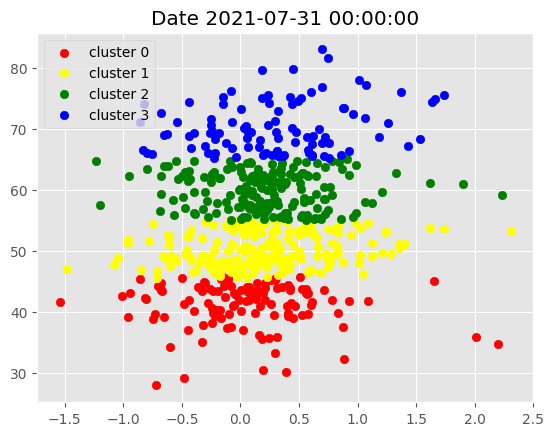

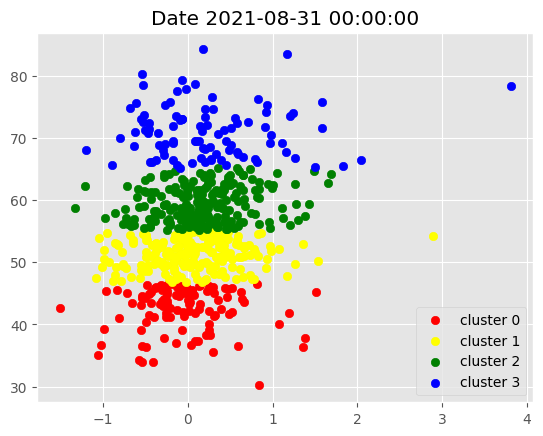

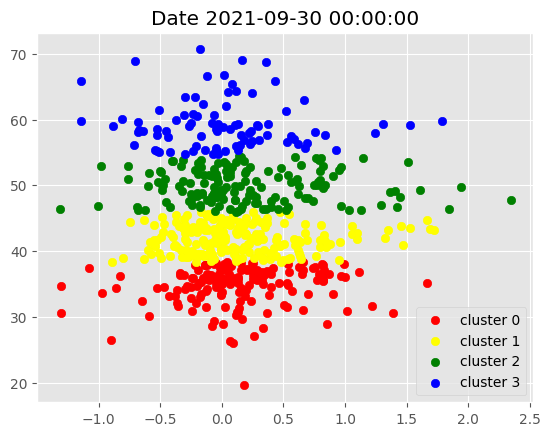

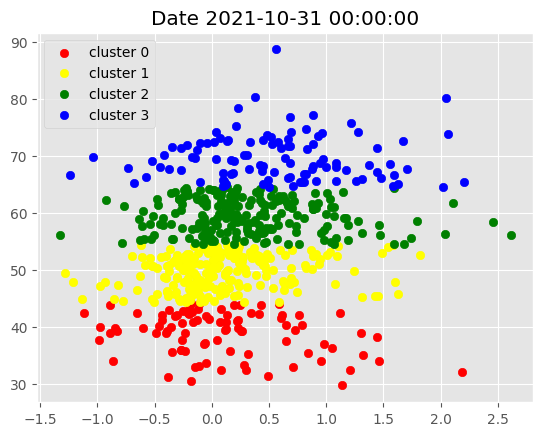

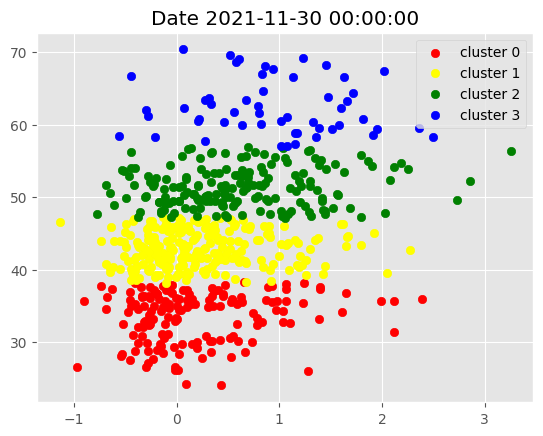

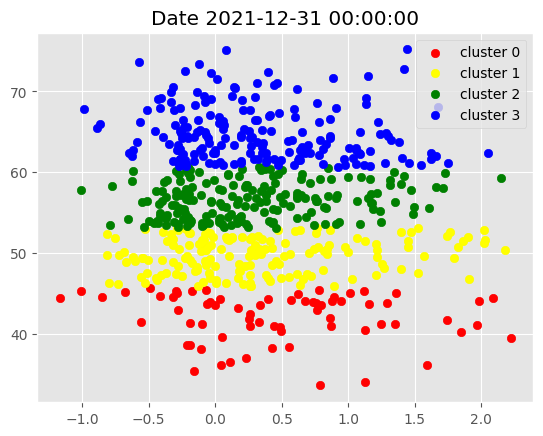

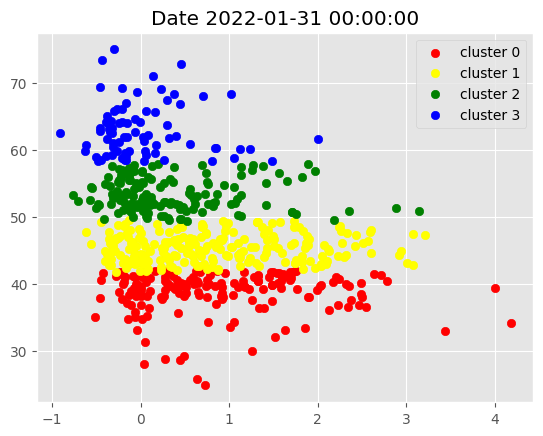

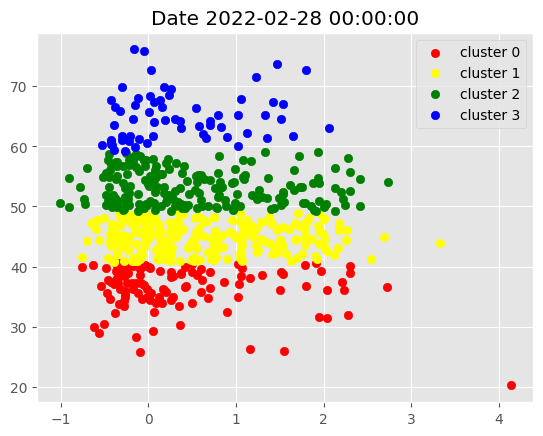

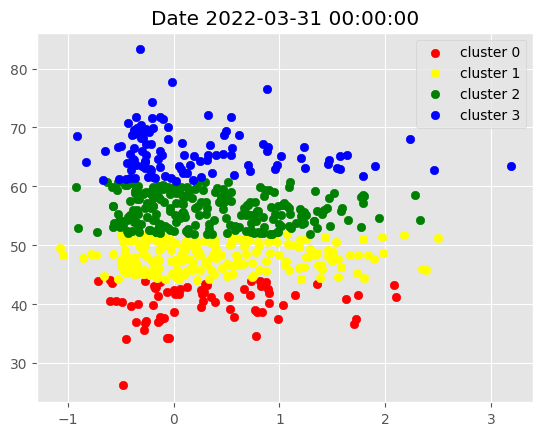

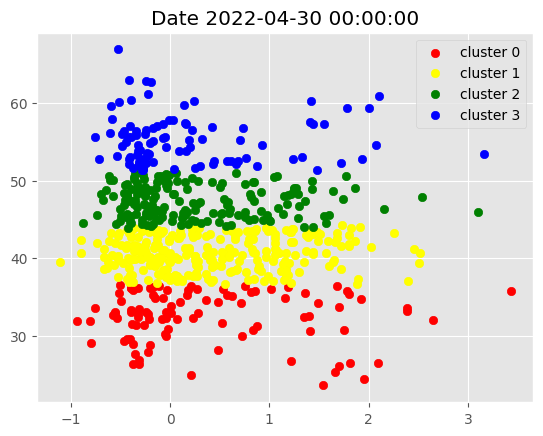

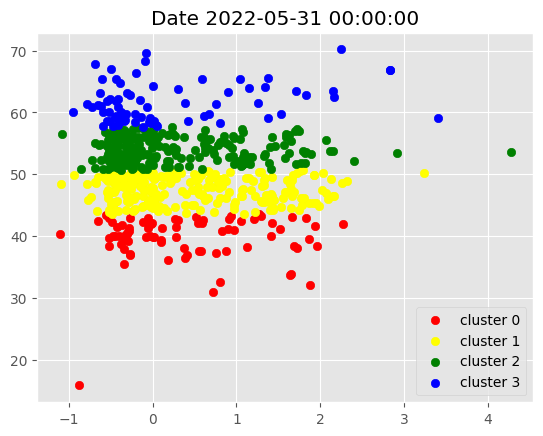

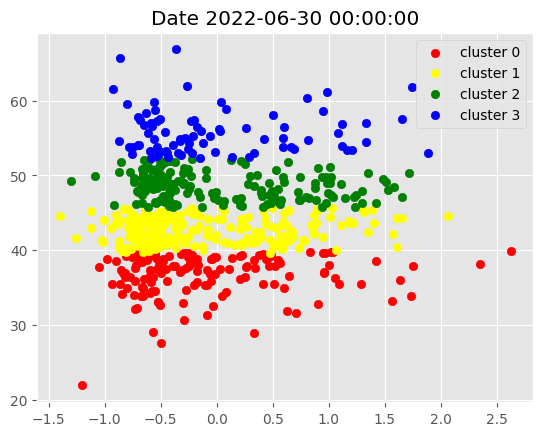

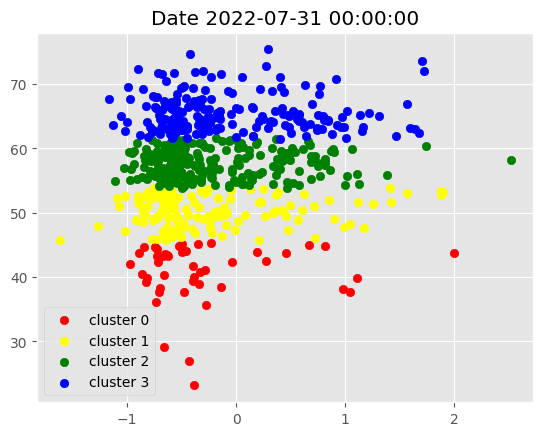

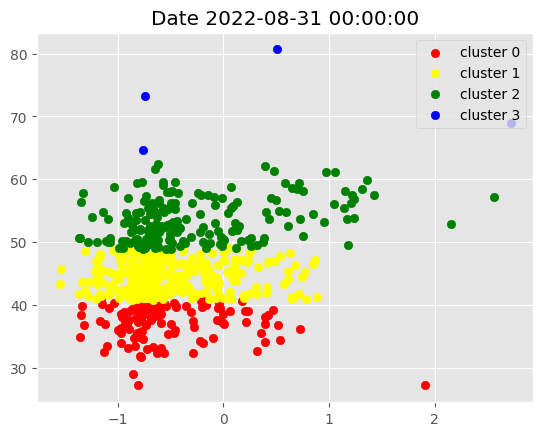

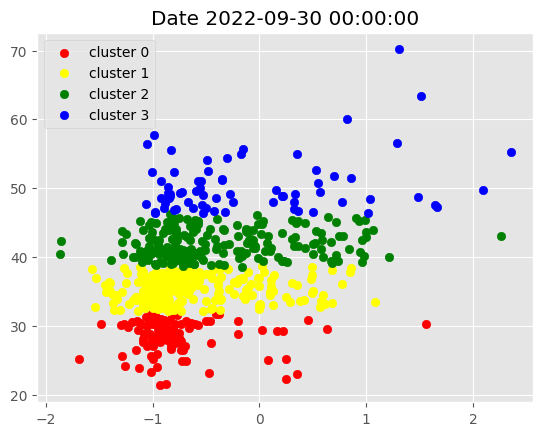

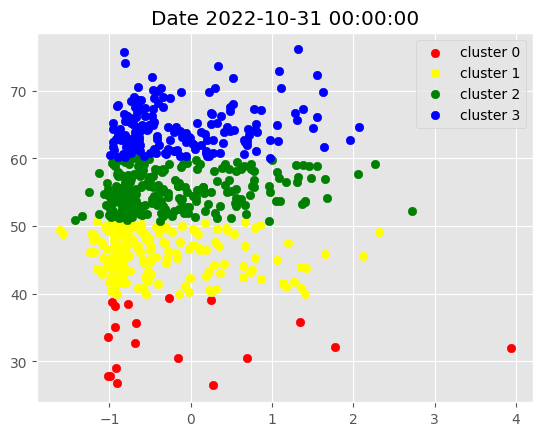

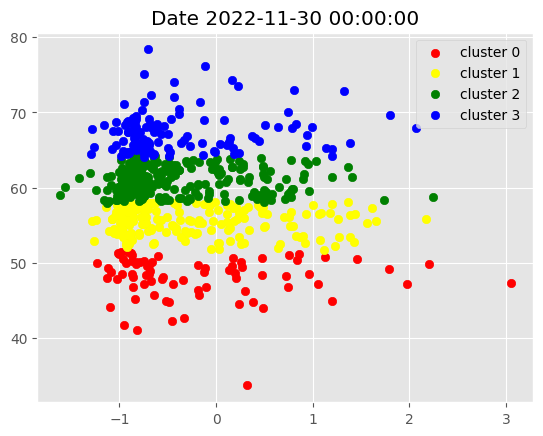

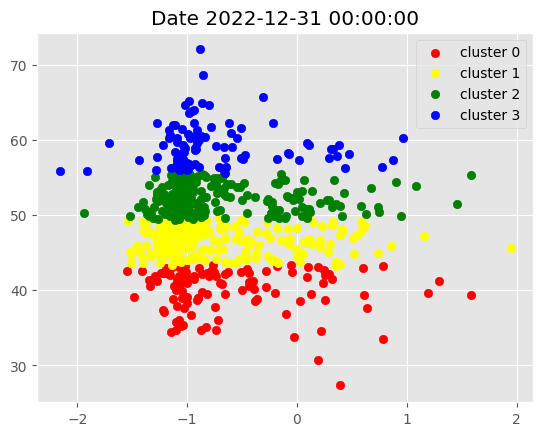

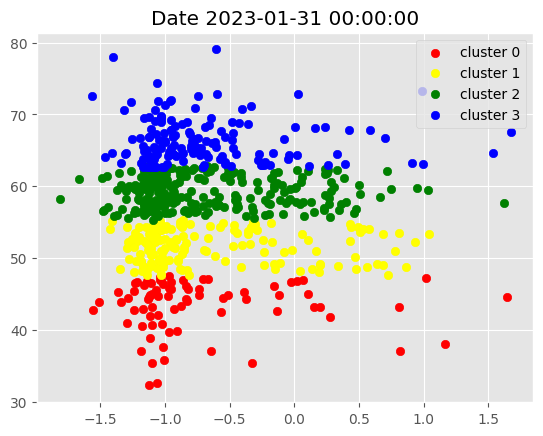

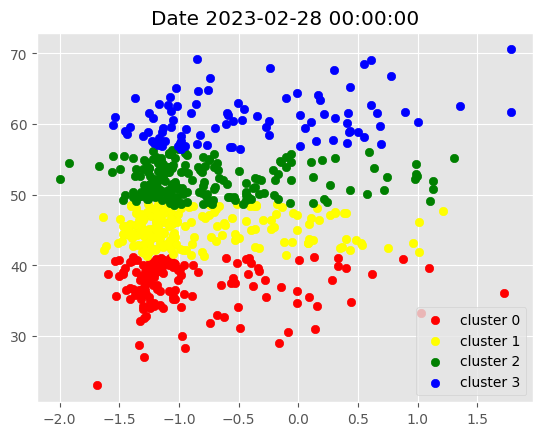

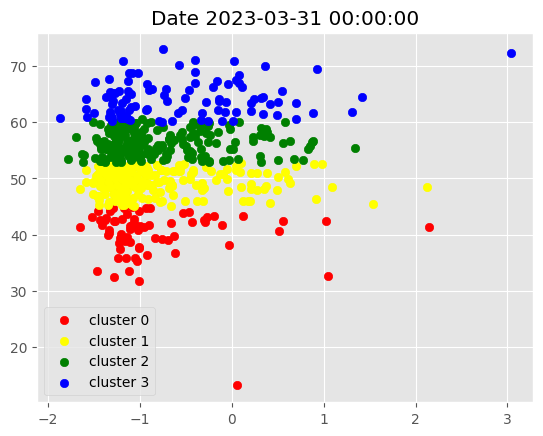

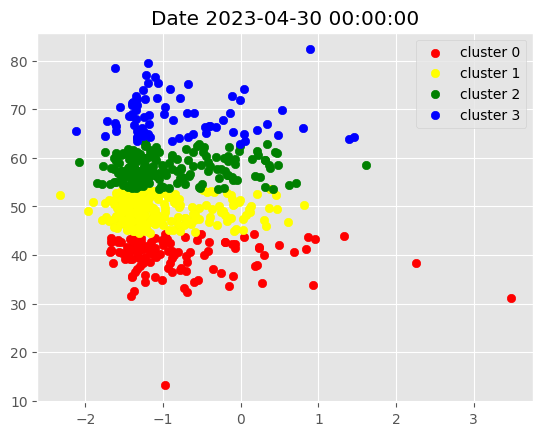

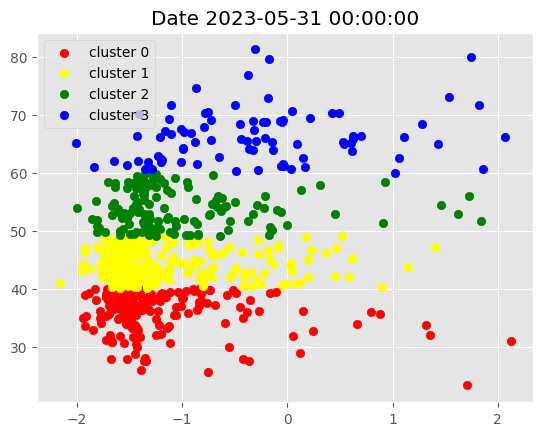

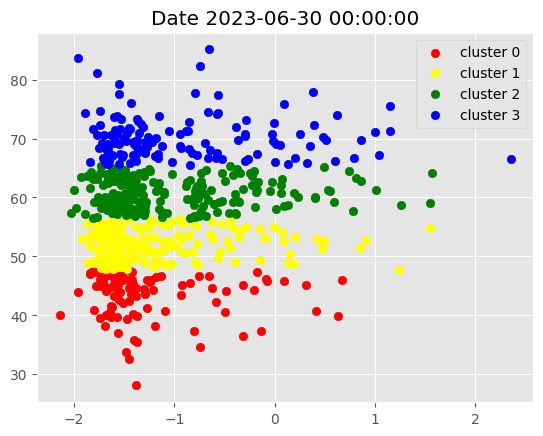

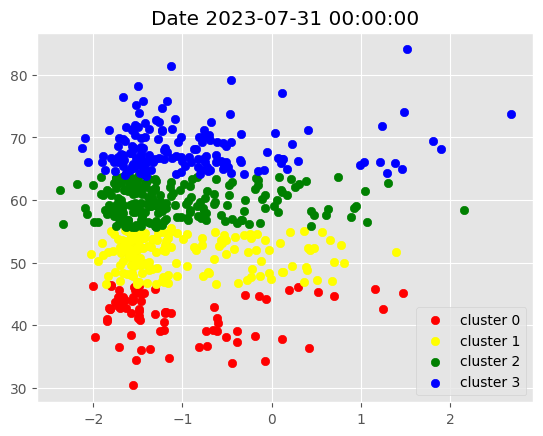

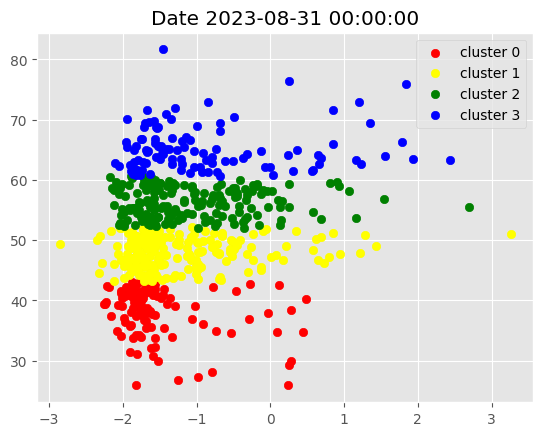

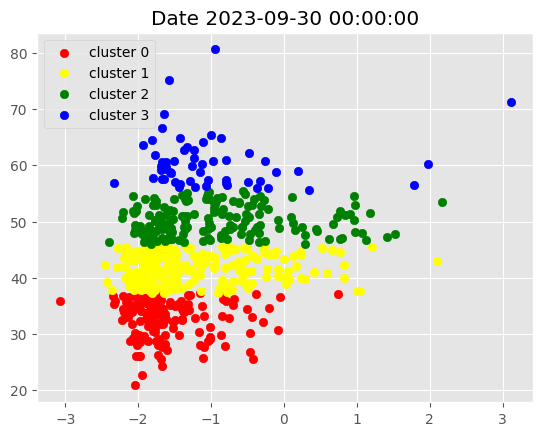

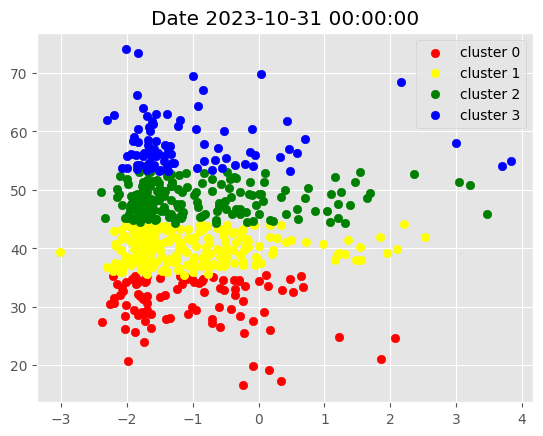

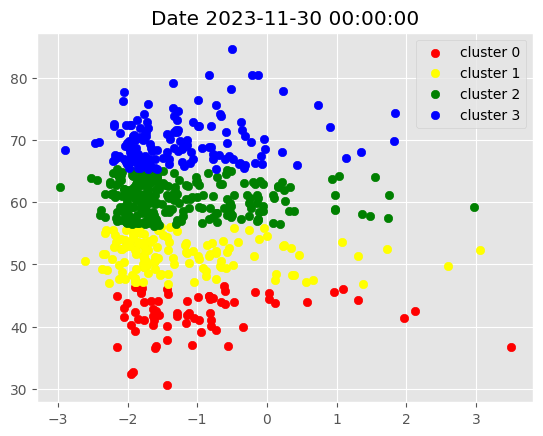

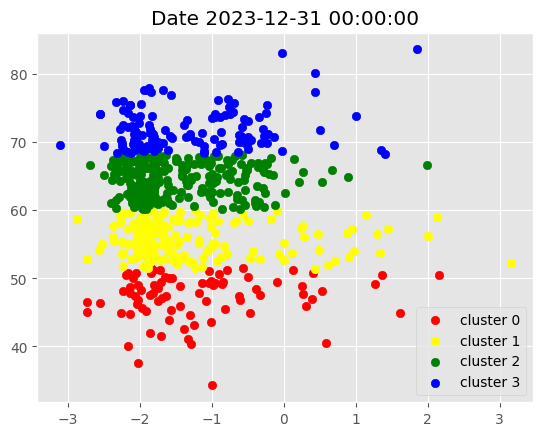

In [ ]:
plt.style.use("ggplot")

for i in df.index.get_level_values("date").unique().tolist():

  g = df.xs(i, level=0)

  plt.title(f"Date {i}")
  plot_clusters(g)

#**Now return and apply pre-defined centroids from above = re-run the algorithm**

In [ ]:
# Find the cluster with the average maximum RSI to maximize our portfolio returns
def find_cluster_with_highest_average(df, column_index):
    cluster_avg_values = df.groupby('cluster')["rsi"].mean()
    highest_avg_cluster = cluster_avg_values.idxmax() #finds the index (cluster label) corresponding to the maximum value in the Series, which represents the cluster with the highest average RSI.
    return highest_avg_cluster

print(f"The cluster with the highests RSI in average is cluster: {find_cluster_with_highest_average(df, 'rsi')}")

The cluster with the highests RSI in average is cluster: 3


##8. For each month select assets based on cluster 3 and form a portfolio based on Efficient Frontier max sharpe ratio optimization

Note: The efficient frontier comprises investment portfolios that offer the highest expected return for a specific level of risk. Take into consideration that a higher Sharpe ratio is better when comparing similar portfolios.

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to **cluster 3.**

* The premise is that we will use the securities in cluster 3 to create an ideal portfolio that should outperform the Nasdaq Composit (^IXIC)

In [ ]:
 # Select the stocks in cluster 3 for each month in the portfolio
filtered_df = df[df["cluster"]==3].copy()

# Create a dictionary with the first day of the next month and all of the stocks of the next month in a list
filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1) # All of the indices are the last day of the month, so we will move them by one day to start the next month

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values("date").unique().tolist() # The beginning of the new month, this is for all months

fixed_dates = {}

for d in dates:

  fixed_dates[d.strftime("%Y-%m-%d")] = filtered_df.xs(d, level=0).index.tolist() #level=0 selects each month

fixed_dates

{'2020-03-01': ['LSXMB', 'REGN'],
 '2020-04-01': ['BRK-A'],
 '2020-05-01': ['AMGN',
  'AMZN',
  'BR',
  'CAG',
  'CDNS',
  'CMG',
  'CMI',
  'COP',
  'CQP',
  'CTRA',
  'DBX',
  'DD',
  'DGX',
  'DHR',
  'DINO',
  'DOCU',
  'DXCM',
  'EBAY',
  'ENPH',
  'EQT',
  'ET',
  'FFIV',
  'GDDY',
  'GEN',
  'GILD',
  'GIS',
  'GLOB',
  'HES',
  'HOLX',
  'HUBS',
  'HUM',
  'IDXX',
  'ILMN',
  'INCY',
  'IQV',
  'KHC',
  'LKQ',
  'LNG',
  'LOGI',
  'MANH',
  'MDB',
  'META',
  'MKTX',
  'MORN',
  'MPLX',
  'MPWR',
  'MRNA',
  'MRO',
  'NEM',
  'NOW',
  'OKTA',
  'PFE',
  'PR',
  'PSX',
  'PYPL',
  'RGEN',
  'ROK',
  'RTO',
  'RVTY',
  'SAIA',
  'SE',
  'SNAP',
  'SNPS',
  'SSNC',
  'TECH',
  'TSCO',
  'TSLA',
  'TTD',
  'TWLO',
  'URI',
  'UTHR',
  'VEEV',
  'VLO',
  'VST',
  'WES',
  'WMB',
  'WSM',
  'WST',
  'YUMC'],
 '2020-06-01': ['A',
  'ADSK',
  'ALB',
  'AME',
  'AZO',
  'BAH',
  'BMRN',
  'CDNS',
  'CELH',
  'CHRW',
  'CHTR',
  'CMG',
  'CPRT',
  'CRL',
  'CSCO',
  'DD',
  'DECK',
  'DE

##**Define the portfolio optimization function**

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio).

In [ ]:
!pip install PyPortfolioOpt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
# This function will take the prices of all the stocks and then optimize the portfolio
def optimize_weights(prices, lower_bound=0):

  returns = expected_returns.mean_historical_return(prices=prices,
                                                    frequency=252) # The number of days that the market is opened for the year

# Calculates the covariance using the prices of the past year
  cov = risk_models.sample_cov(prices=prices,
                               frequency=252)
# Initialize the efficient frontier
  ef = EfficientFrontier(expected_returns=returns,
                         cov_matrix=cov,
                         weight_bounds=(lower_bound, 0.1), # This is a range, not binary classification
                         solver="SCS")

# The higher the sharpe ratio, the better. This means high return and low volatility
  weights = ef.max_sharpe()

  return ef.clean_weights()

In [ ]:
stocks = data.index.get_level_values("ticker").unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values("date").unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values("date").unique()[-1])

new_df

[*********************100%%**********************]  648 of 648 completed


Price        Adj Close                                                  \
Ticker               A        AAPL        ABBV        ABNB         ABT   
Date                                                                     
2018-01-02   64.625557   40.722874   74.280708         NaN   52.831726   
2018-01-03   66.269882   40.715786   75.443092         NaN   52.948551   
2018-01-04   65.772789   40.904903   75.012833         NaN   52.858681   
2018-01-05   66.824371   41.370621   76.318665         NaN   53.011459   
2018-01-08   66.967766   41.216961   75.095886         NaN   52.858681   
...                ...         ...         ...         ...         ...   
2023-12-21  138.705399  194.679993  151.145905  142.089996  107.958466   
2023-12-22  139.334351  193.600006  153.473663  140.800003  108.505814   
2023-12-26  139.573929  193.050003  153.156693  138.720001  108.704857   
2023-12-27  139.583923  193.149994  153.414230  136.550003  109.262161   
2023-12-28  139.534012  193.580002  153.285461  137.000000  109.869232   

Price                                                                ...  \
Ticker            ACI        ACM        ADBE         ADI        ADM  ...   
Date                                                                 ...   
2018-01-02        NaN  36.996296  177.699997   80.471367  33.746391  ...   
2018-01-03        NaN  37.869213  181.039993   81.469681  33.485451  ...   
2018-01-04        NaN  38.202694  183.220001   81.380539  34.049438  ...   
2018-01-05        NaN  37.545547  185.339996   81.710342  33.822170  ...   
2018-01-08        NaN  37.555363  185.039993   81.852959  33.746391  ...   
...               ...        ...         ...         ...        ...  ...   
2023-12-21  22.664724  92.427437  600.140015  196.279999  70.265488  ...   
2023-12-22  22.406153  91.868774  598.750000  197.100006  70.790520  ...   
2023-12-26  22.605051  92.018417  598.260010  198.869995  71.711807  ...   
2023-12-27  22.634888  92.327675  596.080017  199.350006  71.493874  ...   
2023-12-28  22.863623  92.686813  595.520020  200.240005  71.592934  ...   

Price        Volume                                                      \
Ticker          XYL      YUM     YUMC        Z      ZBH    ZBRA      ZG   
Date                                                                      
2018-01-02   877800  1747800  1373300   698100  1818259  310600  277300   
2018-01-03   778800  2554900  2435400   535900  1368664  253000  372700   
2018-01-04   796500  1971200  2186300   884700  1105396  435200  255100   
2018-01-05   666800  1927100  1895900   521200  1095302  301800  127300   
2018-01-08   554700  1599400  1442800   724800  1286985  218600  218600   
...             ...      ...      ...      ...      ...     ...     ...   
2023-12-21  1037000  1211600  2506200  7965400  1971100  282500  925200   
2023-12-22   829300   991500  2236400  2631400  1337800  225900  722100   
2023-12-26   440300   627500  1550200  2753800  1870700  220000  442800   
2023-12-27  1007700  1050400  1110500  2038000  1058600  275700  320100   
2023-12-28   709100   882500  1684900  2872600   662200  193900  578700   

Price                                      
Ticker             ZM         ZS      ZTS  
Date                                       
2018-01-02        NaN        NaN  2135600  
2018-01-03        NaN        NaN  2328200  
2018-01-04        NaN        NaN  2534000  
2018-01-05        NaN        NaN  2166100  
2018-01-08        NaN        NaN  3631400  
...               ...        ...      ...  
2023-12-21  3798700.0  1250500.0  2118600  
2023-12-22  2383600.0   912600.0  1548400  
2023-12-26  2939900.0   770000.0   814600  
2023-12-27  2392300.0   840800.0   766400  
2023-12-28  2330200.0   575300.0   880100  

[1508 rows x 3888 columns]

In [ ]:
# Set the dates
start = df.index.get_level_values("date").unique()[0]-pd.DateOffset(months=12)
end  = df.index.get_level_values("date").unique()[-1]

print(start, end)
# The start date should add 1 year compared to the start date from the data frame above

2019-02-28 00:00:00 2023-12-31 00:00:00


* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"


,Strategy Return
date,
2020-03-02,-0.043770
2020-03-03,-0.003455
2020-03-04,0.033446
2020-03-05,-0.005409
2020-03-06,0.006371
...,...
2023-12-21,0.012619
2023-12-22,0.002590
2023-12-26,0.002706


The algorithm was unable to optmize the max sharpe ratio for weights for the dates above. This means that there will be no investment for those months. To solve this issue, we simply used the equal-weights approach every time that the algorithm cannot find a way to optimize the portfolio weights.

##9. Visualize Portfolio returns and compare to the Nasdaq Composite Index

In [ ]:
# Reset the dates for the analysis
end_date = "2023-12-31"
start_date = "2020-03-02"

# Reset the columns in the portfolio to join the dfs
portfolio_df = portfolio_df.reset_index()

# Create a new dataframe using the weighted return and the dates only
data1 = portfolio_df["date"]
data2 = portfolio_df["Strategy Return"]
portfolio_ret = pd.concat([data1,data2], axis=1)
portfolio_ret = pd.DataFrame(portfolio_ret)
portfolio_ret

,date,Strategy Return
0,2020-03-02,-0.043770
1,2020-03-03,-0.003455
2,2020-03-04,0.033446
3,2020-03-05,-0.005409
4,2020-03-06,0.006371
...,...,...
960,2023-12-21,0.012619
961,2023-12-22,0.002590
962,2023-12-26,0.002706
963,2023-12-27,0.004987


In [ ]:
# Create a dataframe with the returns from the portfolio we created
portfolio_return = (1 + portfolio_ret["Strategy Return"]).cumprod() - 1
cum_port_ret = pd.DataFrame(portfolio_return)
cum_port_ret

,Strategy Return
0,-0.043770
1,-0.047074
2,-0.015202
3,-0.020529
4,-0.014289
...,...
960,0.404840
961,0.408478
962,0.412289
963,0.419332


In [ ]:
# Download the data from the Nasdaq Composite
comp = yf.download(tickers='^IXIC',
                  start=start_date,
                  end=end_date)

comp_ret = np.log(comp[['Adj Close']]).diff().dropna().rename({'Adj Close':'COMP Buy&Hold'}, axis=1)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Show the accumulated returns in a chart
accu_returns = ((1 + comp_ret["COMP Buy&Hold"]).cumprod() - 1)
cum_ret_comp = pd.DataFrame(accu_returns).reset_index()
cum_ret_comp

,Date,COMP Buy&Hold
0,2020-03-03,-0.030403
1,2020-03-04,0.006189
2,2020-03-05,-0.025489
3,2020-03-06,-0.043835
4,2020-03-09,-0.116184
...,...,...
960,2023-12-22,0.451446
961,2023-12-26,0.459324
962,2023-12-27,0.461705
963,2023-12-28,0.461313


In [ ]:
# Merge the data frames
portfolio = pd.merge(cum_port_ret, cum_ret_comp, left_index=True, right_index=True, how="outer")
portfolio = (portfolio[["Date", "COMP Buy&Hold", "Strategy Return"]]).reset_index(drop=True)
portfolio

,Date,COMP Buy&Hold,Strategy Return
0,2020-03-03,-0.030403,-0.043770
1,2020-03-04,0.006189,-0.047074
2,2020-03-05,-0.025489,-0.015202
3,2020-03-06,-0.043835,-0.020529
4,2020-03-09,-0.116184,-0.014289
...,...,...,...
960,2023-12-22,0.451446,0.404840
961,2023-12-26,0.459324,0.408478
962,2023-12-27,0.461705,0.412289
963,2023-12-28,0.461313,0.419332


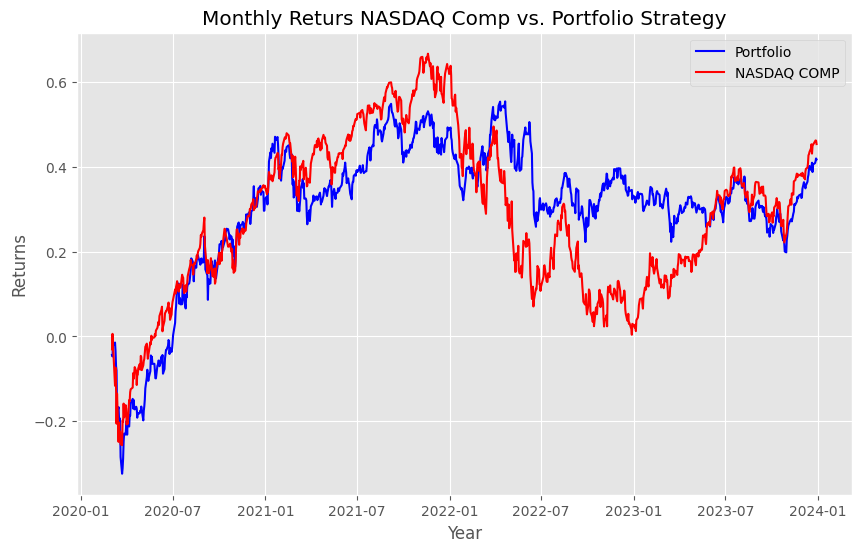

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(portfolio["Date"], portfolio["Strategy Return"], label="Portfolio", c="blue")
plt.plot(portfolio["Date"], portfolio["COMP Buy&Hold"], label="NASDAQ COMP", c="red")

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Monthly Returs NASDAQ Comp vs. Portfolio Strategy')
plt.legend()

# Display the plot
plt.show()

#**Summary:**

Our approach involved crafting a portfolio that consistently outperformed the NASDAQ COMP (^IXIC) index, achieved through the application of an unsupervised machine learning technique known as K-means. Leveraging the Relative Strength Index (RSI), which explains both the velocity and magnitude of stock movements over time, we sought to group clusters containing stocks that indicated sustained appreciation. After identifying the top 100 most promising stocks, we aggregated them into our portfolio.

To refine the portfolio's composition, we developed a function utilizing the PyPortfolioOpt package and the EfficientFrontier optimizer. This function maximized the Sharpe ratio, a measure of risk-adjusted returns.

To optimize the weights of the portfolio we created a function that needed the historical prices as input. This way, the weights on the investments will realign to reach the target RSI of 70+. This will ensure a steady and diversified portfolio with a sustained growth.

In the graph above, the blue line represents the returns generated by our portfolio. Initially, the algorithm mirrored the movement of ^IXIC. However, around January 2021, our custom portfolio's returns began to outpace those of ^IXIC. As 2022 commenced, our investments consistently surpassed ^IXIC's returns. Despite tracking ^IXIC's price movements, as well as following the same momentum, our returns consistently exceeded those of the NASDAQ Composite.

## **Sources:**

https://portfolioslab.com/tools/garman-klass

https://www.investopedia.com/terms/r/rsi.asp

https://www.investopedia.com/terms/b/bollingerbands.asp

https://www.investopedia.com/terms/a/atr.asp

https://www.statsmodels.org/stable/generated/statsmodels.regression.rolling.RollingOLS.html

https://www.investopedia.com/terms/m/macd.asp

https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/macd

https://www.youtube.com/watch?v=9Y3yaoi9rUQ&t=7233s

https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning/blob/main/Algorithmic_Trading_Machine_Learning_Quant_Strategies.ipynb

https://www.zoetis.com/

https://www.investopedia.com/terms/r/rollingreturns.asp

https://rviews.rstudio.com/2018/05/10/rolling-fama-french/


https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp

https://www.quantconnect.com/research/15262/fama-french-five-factors/p1

https://www.investopedia.com/terms/e/efficientfrontier.asp

https://www.investopedia.com/terms/s/sharperatio.asp
